# A look at the distribution of development effort for various Deep Learning projects from Git logs

## A fork of https://gist.github.com/asmeurer/5843625

All credits to Fernando Perez - 2012.

## Collect statistics on the git repositories

In [ ]:
!git clone https://github.com/PaddlePaddle/Paddle
!git clone https://github.com/Lasagne/Lasagne
!git clone https://github.com/bvlc/caffe
!git clone https://github.com/Theano/Theano
!git clone https://github.com/deeplearning4j/deeplearning4j # will take time, 1GB+
!git clone https://github.com/fchollet/keras
!git clone https://github.com/pfnet/chainer
!git clone https://github.com/pytorch/pytorch
!git clone https://github.com/torch/torch7
!git clone https://github.com/tensorflow/tensorflow
!git clone https://github.com/tiny-dnn/tiny-dnn

In [1]:
# Date range for the analysis, leave either as None to cover full history
start_date = '2015-12'
end_date = None

# where to store CSV stats
output_dir = 'git-stats'

# Projects for which you have a git repo
projects = ['tensorflow', 'torch7', 'theano', 'pytorch', 'chainer', 
            'keras', 'paddle', 'lasagne', 'caffe', 'deeplearning4j', 
            'tiny-dnn']

import os
# Base location of your git repos above
repo_base = '.'

from os.path import join
repos = [join(repo_base, p) for p in projects ]

We define a function to collect the stats from a git repo and one to convert that into a CSV file that we can conveniently load afterwards

In [2]:
import subprocess as sp
import tempfile
import os


def git_stats(repo, start_date=None, end_date=None):
    """Compute git shortlog stats since a given date.

    Return a list of pairs of committer, number of commits.
    """
    since = '' if start_date is None else '--since=%s' % start_date
    until = '' if end_date is None else '--until=%s' % end_date
    
    # This is the sensible way to do this, but it may fail...
    output = sp.Popen(['git', 'shortlog', '-sn', since, until], 
                      stdout=sp.PIPE, cwd=repo).communicate()[0]
    
    # This looks a bit absurd, but when running in IPython over zmq (i.e. in the 
    # notebook or qtconsole), *any* form of calling 'git shortlog' produces no
    # output.  In that case, we can use a quirky workaround, that involves using
    # IPython's own system call (that uses pexpect), saving to a temporary file
    # git's output and reading it back.  I think it's a bug in git that shortlog
    # does the wrong thing when not on a tty: `git log` is fine, the problem is specific
    # to the shortlog subcommand, so I'm pretty sure it's a git bug.
    if not output:
        tfile = tempfile.mktemp()
        ip = get_ipython()
        print('cd "%s" && (git shortlog -sn %s %s > %s)' % 
                                    (repo, since, until, tfile))
        ip.system('cd "%s" && (git shortlog -sn %s %s > %s)' % 
                                    (repo, since, until, tfile))
        output = open(tfile).read()
        os.unlink(tfile)
        
    items = []
    for line in output.splitlines():
        p = line.split(None, 1)
        name = p[1].replace(',', '') # commas in the first field will mess up csv loading
        items.append((name, p[0]))
    return items


def csv_stats(repo, start_date=None, end_date=None):
    """Compute git stats and write them to a csv file based on the repo name.
    """
    fname = os.path.split(repo.rstrip('/'))[1] + '.csv'
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    fname = join(output_dir, fname)
    if os.path.isfile(fname):
        print "Not writing file %s, already exists" % fname
        return
    
    stats = git_stats(repo, start_date, end_date)

    with open(fname, 'w') as f:
        f.write('# Git commit stats for date range: %s..%s\n' % (start_date, end_date))
        for s in stats:
            f.write('%s, %s\n' % s)
        print "File written:", f.name, ':', len(stats), 'lines.'

This is the step that actually creates the CSV files.  Note: it will **not** overwrite existing files to protect manual cleanups you may have done.

In [3]:
!rm -f $output_dir/*.csv  # in case you want to nuke and redo
[csv_stats(r, start_date, end_date) for r in repos];

cd "./tensorflow" && (git shortlog -sn --since=2015-12  > /var/folders/7w/k8s371k57dz_0749q92nfy_czk934c/T/tmpW8tK6H)
File written: git-stats/tensorflow.csv : 713 lines.
cd "./torch7" && (git shortlog -sn --since=2015-12  > /var/folders/7w/k8s371k57dz_0749q92nfy_czk934c/T/tmpzXXt3f)
File written: git-stats/torch7.csv : 114 lines.
cd "./theano" && (git shortlog -sn --since=2015-12  > /var/folders/7w/k8s371k57dz_0749q92nfy_czk934c/T/tmpV0LNdn)
File written: git-stats/theano.csv : 221 lines.
cd "./pytorch" && (git shortlog -sn --since=2015-12  > /var/folders/7w/k8s371k57dz_0749q92nfy_czk934c/T/tmpzIG52J)
File written: git-stats/pytorch.csv : 142 lines.
cd "./chainer" && (git shortlog -sn --since=2015-12  > /var/folders/7w/k8s371k57dz_0749q92nfy_czk934c/T/tmptjyLiJ)
File written: git-stats/chainer.csv : 138 lines.
cd "./keras" && (git shortlog -sn --since=2015-12  > /var/folders/7w/k8s371k57dz_0749q92nfy_czk934c/T/tmpfgY8Tu)
File written: git-stats/keras.csv : 385 lines.
cd "./paddle" && (

## Plot results

Now we read from disk the (possibly manually fine-tuned) csv files and make some plots

In [4]:
import os
from glob import glob
from matplotlib import mlab
import matplotlib.pyplot as plt
%matplotlib inline  
from numpy import *

all_csv = set([join(output_dir, p) + '.csv' for p in projects])
csv_files = sorted(glob(join(output_dir, '*.csv')))
missing = all_csv - set(csv_files)
if missing:
    print 'Projects configured but with no CSV file:', sorted(missing)
print 'Files to analyze:\n', csv_files

Files to analyze:
['git-stats/caffe.csv', 'git-stats/chainer.csv', 'git-stats/deeplearning4j.csv', 'git-stats/keras.csv', 'git-stats/lasagne.csv', 'git-stats/paddle.csv', 'git-stats/pytorch.csv', 'git-stats/tensorflow.csv', 'git-stats/theano.csv', 'git-stats/tiny-dnn.csv', 'git-stats/torch7.csv']


In [5]:
def repo_viz(csv_file, xmax=None, norm=None, ax=None, linestyle=None, marker=None):
    """Visualize commit data for a repository.
    """
    if ax is None:
        ax = plt.gca()
    #try:
    arr = loadtxt(csv_file, usecols=[1], delimiter=',')
    #except:
    #    print 'Error converting file', csv_file, 'to array with loadtxt.'
    #    return
    # Now, normalize if required
    if norm == 'first':
        arr /= arr[0]
    elif norm == 'sum':
        arr /= arr.sum()
        
    fname = os.path.split(csv_file.rstrip('/'))[1]
    repo = os.path.splitext(fname)[0]
    
    linestyle = '-' if linestyle is None else linestyle
    marker = 'o' if marker is None else marker
    ax.plot(arange(1, len(arr)+1), arr, lw=1, label=repo, linestyle=linestyle, marker=marker)
    ax.set_xlabel('Individual Committer')
    ax.legend()
    ax.set_xlim(left=1)
    if norm == 'first' or norm == 'sum':
        ax.axhline(0.2, lw=1, color='k', linestyle='--')
        ax.set_ylabel('Commit rate')
    else:
        ax.set_ylabel('# of commits')
    if xmax is not None:
        ax.set_xlim(right=xmax)

Now let's make the figures.  We make a file spec that cycles line styles and markers so we can distinguish these many lines in a single plot.

In [6]:
import itertools as it
linestyles = ['-', '--', '-.']
markers = ['D', 'h', 'o', 'p', 's', 'v', '<', '>', '*']
spec = zip(csv_files, it.cycle(linestyles), it.cycle(markers))

First a plot with the raw commit rates.  This is useful but slightly harder to interpret than a normalized one:

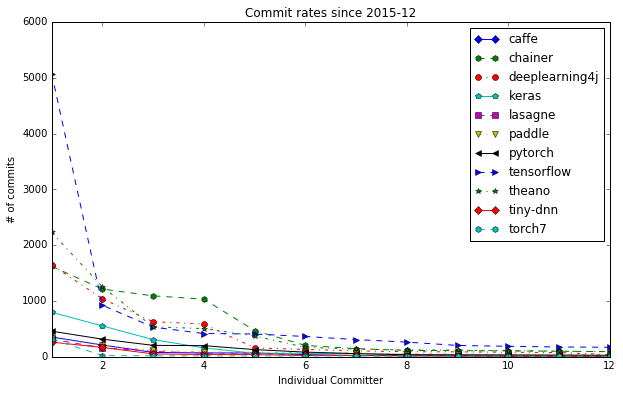

In [7]:
fig2, ax2 = plt.subplots(figsize=(10,6))
[repo_viz(f, xmax=12, ax=ax2, linestyle=ls, marker=m) for f, ls, m in spec ]
ax2.set_title('Commit rates since %s' % start_date);

It is more informative to look at *normalized* commit rates, where in this case we've scaled everything by the most prolific committer, so that we see relative rates.  A line at 20% is drawn for reference, as an (arbitrary) cutoff to count the number of 'very active' committers in each project.

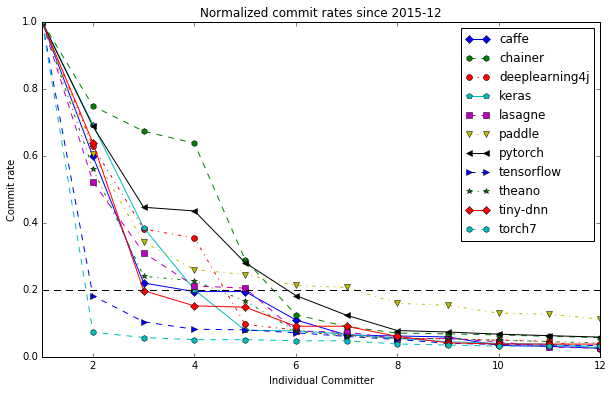

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
[repo_viz(f, xmax=12, norm='first', ax=ax, linestyle=ls, marker=m) for  f, ls, m in spec ]
ax.set_title('Normalized commit rates since %s' % start_date);